In [1]:
#初始工作，读取图片,构造输入矩阵
import numpy as np
import cv2 as cv
import imageio
import matplotlib.pyplot as plt
from PIL import Image
import os
import datetime

data_path = 'D:/airplane/'
save_path = 'D:/save/'
files=os.listdir(data_path)
cnt=0
image = []
for file in files:
    img=imageio.imread(data_path+file)
    i = cv.imread(data_path + file)
    i = cv.resize(i, (256, 256), interpolation=cv.INTER_LINEAR)
    image.append(i)
    np.save(save_path + 'data.npy', image)
    imgs=np.array(img)
    #注意imread返回的是BGR，但并不影响，后续还原图像的时候仍然可以按照此顺序
    imgs_r,imgs_g,imgs_b=imgs[:,:,0],imgs[:,:,1],imgs[:,:,2]
    im_r,im_g,im_b=np.reshape(imgs_r,(-1,1)),np.reshape(imgs_g,(-1,1)),np.reshape(imgs_b,(-1,1)) 
    if cnt==0:
        imageR,imageG,imageB=im_r,im_g,im_b
        cnt=cnt+1
    #如果尺寸不对，需要填0
    else:
        if im_r.shape[0]<65536:
            A=np.zeros(65536-im_r.shape[0]).reshape(65536-im_r.shape[0],1)
            im_r=np.vstack((im_r,A))
            B=np.zeros(65536-im_g.shape[0]).reshape(65536-im_g.shape[0],1)
            im_g=np.vstack((im_g,B))
            C=np.zeros(65536-im_b.shape[0]).reshape(65536-im_b.shape[0],1)
            im_b=np.vstack((im_b,C))
    if cnt!=1:
        #分别得到R、G、B通道的大矩阵
        imageR,imageG,imageB=np.column_stack((imageR,im_r)),np.column_stack((imageG,im_g)),np.column_stack((imageB,im_b))
    cnt=cnt+1

### 方法一：PCA

In [2]:
def PCA(X,alfa):
    #首先求解样本中心点，对应书上第一行算法
    center=np.mean(X,axis=0).reshape(1, -1)
    #对样本进行中心化，对应书上第二行算法
    X=X-center
    #求协方差矩阵，对应书上第三行算法
    C=np.cov(X)
    #求特征值，特征向量，对应书上第四行算法
    sigma,U = np.linalg.eigh(C)
    sigma = sigma[::-1]
    U = U[::-1]
    #特征值选取，对应书上第5行算法
    rank=np.linalg.matrix_rank(X)
    for k in range(rank):
        alpha = sum(sigma[:k])*1.0/sum(sigma)
        if alpha >= alfa:
            break
    num=i#主特征的个数
    #得到W，对应书上第6行算法
    W=U[:,range(num)]
    #投影到新的空间，对应书上第7-8行算法
    Z=np.dot(W.T,X)
    #计算压缩率
    print("compression rate:")
    cr=(np.size(W)+np.size(Z)+np.size(center))/np.size(X)
    print(cr)
    #计算空间节省
    print("space saving:")
    ss=np.size(X)-(np.size(W)+np.size(Z)+np.size(center))
    print(ss)
    #重构图像，并且用二范数求重构误差
    recon_x=np.dot(W,Z)+center
    recon_img=np.uint8(np.absolute(recon_x))
    re_error = np.linalg.norm(recon_img.astype(int) - X.astype(int))
    
    return recon_img,re_error,cr,ss

In [3]:
#在不同超参数alpha下，看reconstruction error, space saving, compressing rate的变化
recon_error=[]
space_saving=[]
compression_rate=[]
running_time=[]
alpha_list = [0.4,0.5,0.6,0.7,0.8,0.9]
for i in alpha_list:
    print('----alpha(' + str(i) + ')----')
    starttime = datetime.datetime.now()
    reconstruction_error=0
    #3个通道分别去做PCA
    r_recon_matrix,r_recon_error,r_cr,r_ss=PCA(imageR.T,i)
    g_recon_matrix,g_recon_error,g_cr,g_ss=PCA(imageG.T,i)
    b_recon_matrix,b_recon_error,b_cr,b_ss=PCA(imageB.T,i)
    #将R,G,B三通道的复原成原图
    recon_img = np.dstack((r_recon_matrix, g_recon_matrix, b_recon_matrix))
    #recon_img = Image.fromarray(recon_img)
    #recon_img.save(str(file))
    
    #100张图片R,G,B的总的重构误差
    for i in range (100):
        k_r=r_recon_matrix[i].reshape(256,256)
        t_r_error = np.linalg.norm(k_r.astype(int) - imgs_r.astype(int)) 
        k_g=g_recon_matrix[i].reshape(256,256)
        t_g_error = np.linalg.norm(k_g.astype(int) - imgs_g.astype(int)) 
        k_b=b_recon_matrix[i].reshape(256,256)
        t_b_error = np.linalg.norm(k_b.astype(int) - imgs_b.astype(int)) 
        reconstruction_error=reconstruction_error+t_r_error +t_g_error+t_b_error
    print("reconstruction error:",reconstruction_error/300)
    recon_error.append(reconstruction_error/300)

    endtime = datetime.datetime.now()
    duringtime = endtime - starttime
    print('runnig time:', duringtime.seconds, '(s)')
    running_time.append(duringtime.seconds)
    space_saving.append((r_ss+g_ss+g_ss)/300)
    compression_rate.append((r_cr+g_cr+b_cr)/3)

----alpha(0.4)----
compression rate:
0.1201678466796875
space saving:
5766068
compression rate:
0.13018310546875
space saving:
5700432
compression rate:
0.13018310546875
space saving:
5700432
reconstruction error: 36350.77923416301
runnig time: 7 (s)
----alpha(0.5)----
compression rate:
0.190274658203125
space saving:
5306616
compression rate:
0.2002899169921875
space saving:
5240980
compression rate:
0.190274658203125
space saving:
5306616
reconstruction error: 35544.16300195552
runnig time: 8 (s)
----alpha(0.6)----
compression rate:
0.270396728515625
space saving:
4781528
compression rate:
0.2804119873046875
space saving:
4715892
compression rate:
0.2804119873046875
space saving:
4715892
reconstruction error: 34993.485016251165
runnig time: 9 (s)
----alpha(0.7)----
compression rate:
0.3805645751953125
space saving:
4059532
compression rate:
0.3805645751953125
space saving:
4059532
compression rate:
0.3805645751953125
space saving:
4059532
reconstruction error: 34434.36302470585
runni

### 方法二： RPCA

In [19]:
from numpy.linalg import norm, svd

def RPCA(D, alfa, λ, lim, maxiteration):
    #对应算法伪代码第一行，进行初始化
    J_D = np.max([norm(D.ravel(), 2), norm(D.ravel(), np.inf)/λ])
    Y = D /J_D
    E = np.zeros(Y.shape)
    μ = 1.25 / norm(D.ravel(), 2)#μ>0
    ro = 1.55#ro>1
    A = np.zeros(Y.shape)
    b = 12.
    k = 0#表示迭代次数
    Z = D-A-E
    #对应算法伪代码第二行 while not converged do
    while ((k < maxiteration) and (norm(Z, 'fro') / norm(D, 'fro')>=lim)):
        E_0 = D-A+(1/μ)*Y
        E_k = np.minimum(E_0+λ/μ,0)+np.maximum(E_0-λ/μ, 0)
        #对应算法伪代码第四行
        U,S,V = svd(D-E_k+(1/μ)*Y, full_matrices=False)
        a = (S>1/μ).shape[0]
        if a >= b:
            b = np.min([Y.shape[1],a+round(0.05*Y.shape[1])])
        else:
            b = np.min([a+1,Y.shape[1]])
        #对应伪代码第五行
        A_k = np.dot(np.dot(U[:,:a],np.diag(S[:a]-1/μ)),V[:a,:])
        A,E = A_k,E_k
#         print(k)
        Z = D-A-E
        #对应伪代码第八行
        Y = Y+μ*Z
        μ = np.min([μ*ro, μ*1.1e7])
        k += 1
    return PCA(A.T,alfa)

In [20]:
#在不同超参数alpha下，看reconstruction error, space saving, compressing rate的变化
recon_error1=[]
space_saving1=[]
compression_rate1=[]
running_time1=[]
for i in alpha_list:
    print('----alpha(' + str(i) + ')----')
    starttime = datetime.datetime.now()
    reconstruction_error=0
    #3个通道分别去做RPCA
    r_recon_matrix,r_recon_error,r_cr,r_ss=RPCA(imageR,i,0.01,1e-7,1000)
    g_recon_matrix,g_recon_error,g_cr,g_ss=RPCA(imageG,i,0.01,1e-7,1000)
    b_recon_matrix,b_recon_error,b_cr,b_ss=RPCA(imageB,i,0.01,1e-7,1000)
    #将R,G,B三通道的复原成原图
    recon_img = np.dstack((r_recon_matrix, g_recon_matrix, b_recon_matrix))
    #recon_img = Image.fromarray(recon_img)
    #recon_img.save(str(file))
    
    #100张图片R,G,B的总的重构误差
    for i in range (100):
        k_r=r_recon_matrix[i].reshape(256,256)
        t_r_error = np.linalg.norm(k_r.astype(int) - imgs_r.astype(int)) 
        k_g=g_recon_matrix[i].reshape(256,256)
        t_g_error = np.linalg.norm(k_g.astype(int) - imgs_g.astype(int)) 
        k_b=b_recon_matrix[i].reshape(256,256)
        t_b_error = np.linalg.norm(k_b.astype(int) - imgs_b.astype(int)) 
        reconstruction_error=reconstruction_error+t_r_error +t_g_error+t_b_error
    print("reconstruction error:",reconstruction_error/300)
    recon_error1.append(reconstruction_error/300)

    endtime = datetime.datetime.now()
    duringtime = endtime - starttime
    print('runnig time:', duringtime.seconds, '(s)')
    running_time1.append(duringtime.seconds)
    space_saving1.append((r_ss+g_ss+g_ss)/300)
    compression_rate1.append((r_cr+g_cr+b_cr)/3)

----alpha(0.4)----
compression rate:
0.1001373291015625
space saving:
5897340
compression rate:
0.1001373291015625
space saving:
5897340
compression rate:
0.1001373291015625
space saving:
5897340
reconstruction error: 36737.61270637242
runnig time: 111 (s)
----alpha(0.5)----
compression rate:
0.1602288818359375
space saving:
5503524
compression rate:
0.1602288818359375
space saving:
5503524
compression rate:
0.1602288818359375
space saving:
5503524
reconstruction error: 36162.615769190255
runnig time: 105 (s)
----alpha(0.6)----
compression rate:
0.230335693359375
space saving:
5044072
compression rate:
0.230335693359375
space saving:
5044072
compression rate:
0.230335693359375
space saving:
5044072
reconstruction error: 35672.74690286046
runnig time: 102 (s)
----alpha(0.7)----
compression rate:
0.3204730224609375
space saving:
4453348
compression rate:
0.3204730224609375
space saving:
4453348
compression rate:
0.3204730224609375
space saving:
4453348
reconstruction error: 35168.6129824

方法三：2D pca

In [6]:
data =np.load(save_path + 'data.npy')
print(data.shape)
data_r=data[:,:,:,0]
data_g=data[:,:,:,0]
data_b=data[:,:,:,0]

(100, 256, 256, 3)


In [7]:
def twoD_PCA(X,alfa):
    #求样本均值
    center = np.zeros((X.shape[1],X.shape[2]))
    for i in range(X.shape[0]):
        center += X[i,:,:]/(X.shape[0]*1.0)
    #样本中心化
    X=X-center
    #计算协方差矩阵
    G_t = np.zeros((X.shape[2],X.shape[2]))
    for j in range(X.shape[0]):
        img = X[j,:,:]
        tmp = img-center
        G_t = G_t + np.dot(tmp.T,tmp)/(X.shape[0]*1.0)
    sigma,u=np.linalg.eig(G_t)
    #对特征值进行排序
    idx=np.argsort(sigma)
    idx=idx[::-1]
    u=u[:,idx]
    sigma=sigma[idx]
    #特征值选取
    sigma_sum=np.sum(sigma)
    for i in range(X.shape[2]):
        p_sigma=p_sigma+sigma[i]
        if p_sigma>(alfa*sigma_sum):
            break
    num=i#主特征的个数
    #得到W
    W=u[:,range(num)]
    # 压缩后的图像
    newX = np.dot(X, W)
    #计算压缩率
    print("compression rate:")
    cr=(np.size(W)+np.size(newX)+np.size(center))/np.size(X)
    print(cr)
    #计算空间节省
    print("space saving:")
    ss=np.size(X)-(np.size(W)+np.size(newX)+np.size(center))
    print(ss)
    #重建图像，变回X，并且用二范数求重构误差
    recon_X=np.dot(newX,W.T)+center
    recon_img=np.uint8(np.absolute(recon_X))
    re_error = np.linalg.norm(recon_img.astype(int) - X.astype(int))
    return recon_img,re_error,cr,ss

In [8]:
#在不同超参数alpha下，看reconstruction error, space saving, compressing rate的变化
recon_error2=[]
space_saving2=[]
compression_rate2=[]
running_time2=[]
for i in alpha_list:
    print('----alpha(' + str(i) + ')----')
    starttime = datetime.datetime.now()
    reconstruction_error=0
    #3个通道分别去做2DPCA
    r_recon_matrix,r_recon_error,r_cr,r_ss=twoD_PCA(data_r,i)
    g_recon_matrix,g_recon_error,g_cr,g_ss=twoD_PCA(data_g,i)
    b_recon_matrix,b_recon_error,b_cr,b_ss=twoD_PCA(data_b,i)
    #将R,G,B三通道的复原成原图
    recon_img = np.dstack((r_recon_matrix, g_recon_matrix, b_recon_matrix))
    #recon_img = Image.fromarray(recon_img)
    #recon_img.save(str(file))
    
    #100张图片R,G,B的总的重构误差
    for i in range (100):
        k_r=r_recon_matrix[i].reshape(256,256)
        t_r_error = np.linalg.norm(k_r.astype(int) - imgs_r.astype(int)) 
        k_g=g_recon_matrix[i].reshape(256,256)
        t_g_error = np.linalg.norm(k_g.astype(int) - imgs_g.astype(int)) 
        k_b=b_recon_matrix[i].reshape(256,256)
        t_b_error = np.linalg.norm(k_b.astype(int) - imgs_b.astype(int)) 
        reconstruction_error=reconstruction_error+t_r_error +t_g_error+t_b_error
    print("reconstruction error:",reconstruction_error/300)
    recon_error2.append(reconstruction_error/300)

    endtime = datetime.datetime.now()
    duringtime = endtime - starttime
    print('runnig time:', duringtime.seconds, '(s)')
    running_time2.append(duringtime.seconds)
    space_saving2.append((r_ss+g_ss+g_ss)/300)
    compression_rate2.append((r_cr+g_cr+b_cr)/3)

----alpha(0.4)----
compression rate:
0.017890625
space saving:
6436352
compression rate:
0.017890625
space saving:
6436352
compression rate:
0.017890625
space saving:
6436352
construction error: 12978.982623866688
runnig time: 1 (s)
----alpha(0.5)----
compression rate:
0.0218359375
space saving:
6410496
compression rate:
0.0218359375
space saving:
6410496
compression rate:
0.0218359375
space saving:
6410496
construction error: 12979.215455912556
runnig time: 1 (s)
----alpha(0.6)----
compression rate:
0.033671875
space saving:
6332928
compression rate:
0.033671875
space saving:
6332928
compression rate:
0.033671875
space saving:
6332928
construction error: 12979.868845410363
runnig time: 1 (s)
----alpha(0.7)----
compression rate:
0.0455078125
space saving:
6255360
compression rate:
0.0455078125
space saving:
6255360
compression rate:
0.0455078125
space saving:
6255360
construction error: 12980.470306261132
runnig time: 1 (s)
----alpha(0.8)----
compression rate:
0.073125
space saving:
60

### 方法四: KPCA

In [9]:
def linear(x1,x2,a=1,c=0,b=1):
    x = np.dot(x1, x2)
    x = np.power((a*x+c),b)
    return x

def rbf(x1,x2,gamma = 3):
    x = np.dot((x1-x2),(x1-x2))
    x = np.exp(-gamma*x)
    return x
    
    
def kpca(X, alfa, kernel):
    N,D = np.shape(X)
    K = np.zeros([N,N])
    # 利用核函数计算K
    for i in range(N):
        for j in range(N):
            K[i,j]=kernel(X[i],X[j])
    # 对K进行中心化
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    #求特征值，特征向量，对应书上第四行算法
    sigma,U = np.linalg.eigh(C)
    sigma = sigma[::-1]
    U = U[::-1]
    #特征值选取，对应书上第5行算法
    rank=np.linalg.matrix_rank(X)
    for k in range(rank):
        alpha = sum(sigma[:k])*1.0/sum(sigma)
        if alpha >= alfa:
            break
    num=i#主特征的个数
    # 选取较大的特征值
    val = U[num][0]
    vector = U[:, range(num)]
    # 进行正则
    val = val**(1/2)
    u = vector/val 
    # 进行降维
    new_X = np.dot(K, u)
    #计算压缩率
    print("compression rate:")
    cr=(np.size(u)+np.size(new_X))/np.size(X)
    print(cr)
    #计算空间节省
    print("space saving:")
    ss=np.size(X)-(np.size(u)+np.size(new_X))
    print(ss)
    return cr,ss

### kernel为rbf

In [10]:
#在不同超参数alpha下，看reconstruction error, space saving, compressing rate的变化
space_saving3=[]
compression_rate3=[]
running_time3=[]
for i in alpha_list:
    print('----alpha(' + str(i) + ')----')
    starttime = datetime.datetime.now()
    r_cr,r_ss=kpca(imageR.T,i,kernel=rbf)
    g_cr,g_ss=kpca(imageG.T,i,kernel=rbf)
    b_cr,b_ss=kpca(imageB.T,i,kernel=rbf)
    
    endtime = datetime.datetime.now()
    duringtime = endtime - starttime
    print('runnig time:', duringtime.seconds, '(s)')
    running_time3.append(duringtime.seconds)
    space_saving3.append((r_ss+g_ss+g_ss)/300)
    compression_rate3.append((r_cr+g_cr+b_cr)/3)

----alpha(0.4)----
compression rate:
0.00115966796875
space saving:
6546000
compression rate:
0.00115966796875
space saving:
6546000
compression rate:
0.00115966796875
space saving:
6546000
runnig time: 108 (s)
----alpha(0.5)----
compression rate:
0.00146484375
space saving:
6544000
compression rate:
0.00146484375
space saving:
6544000
compression rate:
0.00146484375
space saving:
6544000
runnig time: 109 (s)
----alpha(0.6)----
compression rate:
0.00177001953125
space saving:
6542000
compression rate:
0.00177001953125
space saving:
6542000
compression rate:
0.00177001953125
space saving:
6542000
runnig time: 107 (s)
----alpha(0.7)----
compression rate:
0.0020751953125
space saving:
6540000
compression rate:
0.0020751953125
space saving:
6540000
compression rate:
0.0020751953125
space saving:
6540000
runnig time: 105 (s)
----alpha(0.8)----
compression rate:
0.00238037109375
space saving:
6538000
compression rate:
0.00238037109375
space saving:
6538000
compression rate:
0.00238037109375


### kernel为linear

In [11]:
#在不同超参数alpha下，看reconstruction error, space saving, compressing rate的变化
space_saving5=[]
compression_rate5=[]
running_time5=[]
for i in alpha_list:
    print('----alpha(' + str(i) + ')----')
    starttime = datetime.datetime.now()
#     print(i)
    r_cr,r_ss=kpca(array_nr.T,i,kernel=linear)
    g_cr,g_ss=kpca(array_ng.T,i,kernel=linear)
    b_cr,b_ss=kpca(array_nb.T,i,kernel=linear)

    endtime = datetime.datetime.now()
    duringtime = endtime - starttime
    print('runnig time:', duringtime.seconds, '(s)')
    running_time5.append(duringtime.seconds)
    space_saving5.append((r_ss+g_ss+g_ss)/300)
    compression_rate5.append((r_cr+g_cr+b_cr)/3)

----alpha(0.4)----
compression rate:
0.0001220703125
space saving:
6552800
compression rate:
0.000152587890625
space saving:
6552600


<ipython-input-9-b88852f284f1>:52: RuntimeWarning: invalid value encountered in double_scalars
  eigval = eigval**(1/2)


compression rate:
0.0001220703125
space saving:
6552800
runnig time: 26 (s)
----alpha(0.5)----
compression rate:
0.000274658203125
space saving:
6551800
compression rate:
0.00030517578125
space saving:
6551600
compression rate:
0.000274658203125
space saving:
6551800
runnig time: 26 (s)
----alpha(0.6)----
compression rate:
0.000518798828125
space saving:
6550200
compression rate:
0.000579833984375
space saving:
6549800
compression rate:
0.00054931640625
space saving:
6550000
runnig time: 25 (s)
----alpha(0.7)----
compression rate:
0.000823974609375
space saving:
6548200
compression rate:
0.000885009765625
space saving:
6547800
compression rate:
0.0008544921875
space saving:
6548000
runnig time: 26 (s)
----alpha(0.8)----
compression rate:
0.001251220703125
space saving:
6545400
compression rate:
0.001312255859375
space saving:
6545000
compression rate:
0.00128173828125
space saving:
6545200
runnig time: 27 (s)
----alpha(0.9)----
compression rate:
0.001861572265625
space saving:
6541400


### 作图
由于kpca的kernel常用linear,rbf这两种方式，故比较在本次实验的数据集上，选用哪种kernel效果更好

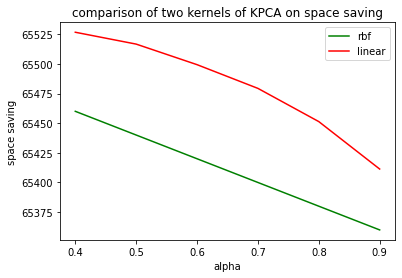

In [12]:
x_axix=[]
for i in alpha_list:
    x_axix.append(i)
plt.title('comparison of two kernels of KPCA on space saving')
plt.plot(x_axix, space_saving3, color='green', label='rbf')
plt.plot(x_axix, space_saving5,  color='red', label='linear')
plt.legend() 
plt.xlabel('alpha')
plt.ylabel('space saving')
plt.show()

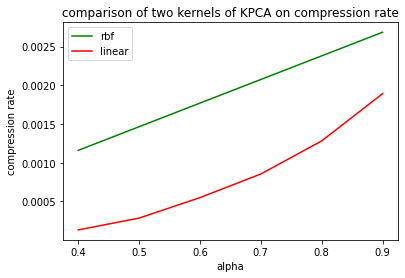

In [13]:
x_axix=[]
for i in alpha_list:
    x_axix.append(i)
plt.title('comparison of two kernels of KPCA on compression rate')
plt.plot(x_axix, compression_rate3, color='green', label='rbf')
plt.plot(x_axix, compression_rate5,  color='red', label='linear')
plt.legend() # 显示图例

plt.xlabel('alpha')
plt.ylabel('compression rate')
plt.show()

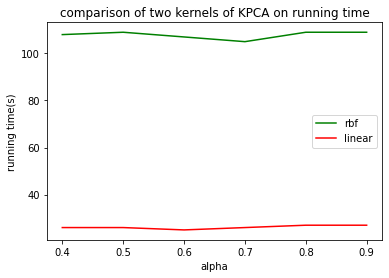

In [14]:
x_axix=[]
for i in alpha_list:
    x_axix.append(i)
plt.title('comparison of two kernels of KPCA on running time')
plt.plot(x_axix, running_time3, color='green', label='rbf')
plt.plot(x_axix, running_time5,  color='red', label='linear')
plt.legend()

plt.xlabel('alpha')
plt.ylabel('running time(s)')
plt.show()

### 四种方法进行比较

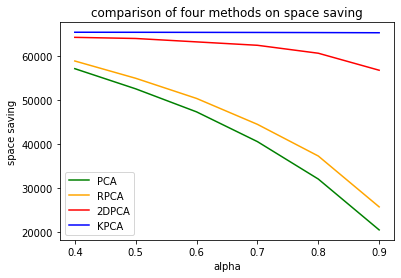

In [15]:
x_axix=[]
for i in alpha_list:
    x_axix.append(i)
plt.title('comparison of four methods on space saving')
plt.plot(x_axix, space_saving, color='green', label='PCA')
plt.plot(x_axix, space_saving1,  color='orange', label='RPCA')
plt.plot(x_axix, space_saving2,  color='red', label='2DPCA')
plt.plot(x_axix, space_saving5,  color='blue', label='KPCA')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('space saving')
plt.show()

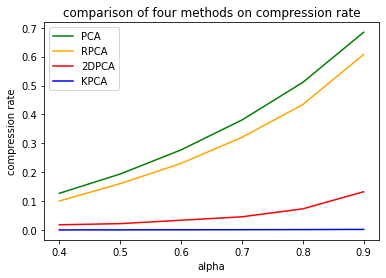

In [16]:
x_axix=[]
for i in alpha_list:
    x_axix.append(i)
plt.title('comparison of four methods on compression rate')
plt.plot(x_axix, compression_rate, color='green', label='PCA')
plt.plot(x_axix, compression_rate1,  color='orange', label='RPCA')
plt.plot(x_axix, compression_rate2,  color='red', label='2DPCA')
plt.plot(x_axix, compression_rate5,  color='blue', label='KPCA')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('compression rate')
plt.show()

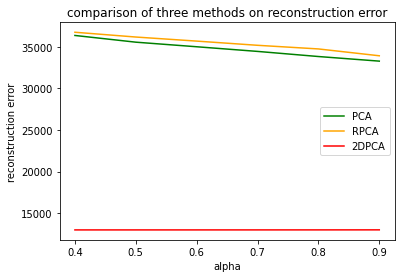

In [17]:
x_axix=[]
for i in alpha_list:
    x_axix.append(i)
plt.title('comparison of three methods on reconstruction error')
plt.plot(x_axix, recon_error, color='green', label='PCA')
plt.plot(x_axix, recon_error1,  color='orange', label='RPCA')
plt.plot(x_axix, recon_error2,  color='red', label='2DPCA')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('reconstruction error')
plt.show()

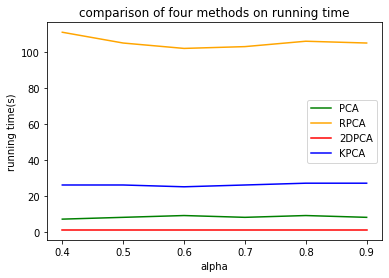

In [21]:
x_axix=[]
for i in alpha_list:
    x_axix.append(i)
plt.title('comparison of four methods on running time')
plt.plot(x_axix, running_time, color='green', label='PCA')
plt.plot(x_axix, running_time1,  color='orange', label='RPCA')
plt.plot(x_axix, running_time2,  color='red', label='2DPCA')
plt.plot(x_axix, running_time5,  color='blue', label='KPCA')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('running time(s)')
plt.show()